In [1]:
import copy
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np

from alns import ALNS, State
from alns.accept import *
from alns.stop import *
from alns.weights import *

In [2]:
%matplotlib inline

In [3]:
SEED = 42

In [4]:
np.random.seed(SEED)

# Weight schemes and acceptance criteria

The `alns` package offers a number of different weight schemes, and acceptance and stopping criteria. In this notebook, we show these in action solving a toy knapsack problem. Along the way we explain how they work, and show how you can use them in your ALNS heuristic.

In our toy [0/1-knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem), there are $n = 100$ items $i$ with profit $p_i > 0$ and weight $w_i > 0$. The goal is to find a subset of the items that maximizes the profit, while keeping the total weight below a given limit $W$. The problem then reads follows:
\begin{align}
      \text{maximise } & \sum_{i=1}^n p_i x_i \\
    \text{subject to } & \sum_{i=1}^n w_i x_i \le W \text{ and } x_i \in \{0, 1\}.
\end{align}

First we quickly set up everything required for solving the problem with ALNS. In particular, we define a solution state, and a few destroy and repair operators. Our goal is not to solve this problem very well, so we set up only the bare minimum needed to get the ALNS algorithm going.

In [5]:
n = 100
p = np.random.randint(1, 100, size=n)
w = np.random.randint(10, 50, size=n)
W = 1_000

# Percentage of items to remove in each iteration
destroy_rate = .25

In [6]:
@dataclass
class KnapsackState(State):
    """
    Solution class for the 0/1 knapsack problem. It stores the current
    solution as a vector of binary variables, one for each item.
    """
    x: np.ndarray

    def objective(self) -> int:
        # Negative p since ALNS expects a minimisation problem.
        return -p @ self.x

    def weight(self) -> int:
        return w @ self.x

### Destroy operators

We implement two operators:
- A simple random destroy operator, which removes items from the knapsack at random.
- A destroy operator that removes items based on their relative merits, that is, for an item $i$ currently in the knapsack, it removes those whose $p_i / w_i$ values are smallest.

In [7]:
def to_destroy(state: KnapsackState) -> int:
    return int(destroy_rate * state.x.sum())

In [8]:
def random_remove(state: KnapsackState, rnd_state):
    state = copy.deepcopy(state)

    to_remove = rnd_state.choice(np.arange(n),
                                 size=to_destroy(state),
                                 p=state.x / state.x.sum())

    state.x[to_remove] = 0

    return state

In [9]:
def worst_remove(state: KnapsackState, rnd_state):
    state = copy.deepcopy(state)

    merit = state.x * p / w

    by_merit = np.argsort(-merit)
    by_merit = by_merit[by_merit > 0]

    for item in by_merit[:to_destroy(state)]:
        state.x[item] = 0

    return state

### Repair operators

We implement only the random repair operator. The focus of this notebook is not on solving the knapsack problem very well, but rather to showcase the different weight schemes and acceptance criteria.

In [10]:
def random_repair(state: KnapsackState, rnd_state):
    while True:
        unselected = np.argwhere(state.x == 0)
        rnd_state.shuffle(unselected)

        for item in unselected:
            if state.weight() + w[item] <= W:
                state.x[item] = 1
                break
        else:
            return state

### ALNS

In [11]:
def make_alns() -> ALNS:
    rnd_state = np.random.RandomState(SEED)
    alns = ALNS(rnd_state)

    alns.add_destroy_operator(random_remove)
    alns.add_destroy_operator(worst_remove)

    alns.add_repair_operator(random_repair)

    return alns

In [12]:
# Terrible - but simple - first solution, where only the first item is
# selected.
init_sol = KnapsackState(np.zeros(n))
init_sol.x[0] = 1

# Weight schemes

We now have everything set-up for solving the problem. We will now look at the weight schemes the `alns` package offers. Here, we use the `HillClimbing` acceptance criterion, which only accepts better solutions.

In [13]:
crit = HillClimbing()

## Simple weights

The `SimpleWeights` weight scheme updates operator weights according as a convex combination of the current weight, and the new score.

When the algorithm starts, all operators $i$ are assigned weight $\omega_i = 1$. In each iteration, a destroy and repair operator $d$ and $r$ are selected by the ALNS algorithm, based on the current weights $\omega_i$. These operators are applied to the current solution, resulting in a new candidate solution. This candidate is evaluated by the ALNS algorithm, which leads to one of four outcomes:

1. The candidate solution is a new global best.
2. The candidate solution is better than the current solution, but not a global best.
3. The candidate solution is accepted.
4. The candidate solution is rejected.

Each of these four outcomes is assigned a score $s_j$ ($j = 1,...,4$). After observing outcome $j$, the weights of the destroy and repair operator $d$ and $r$ that were applied are updated as follows:
$$ \omega_d = \theta \omega_d + (1 - \theta) s_j, $$
$$ \omega_r = \theta \omega_r + (1 - \theta) s_j, $$
where $0 \le \theta \le 1$ (known as the _operator decay rate_) is a parameter.

In [14]:
weights = SimpleWeights(scores=[5, 2, 1, 0.5],
                        num_destroy=2,
                        num_repair=1,
                        op_decay=0.8)

alns = make_alns()
res = alns.iterate(init_sol, weights, crit, MaxIterations(10_000))

print(f"Found solution with objective {-res.best_state.objective()}.")

Found solution with objective 2876.0.


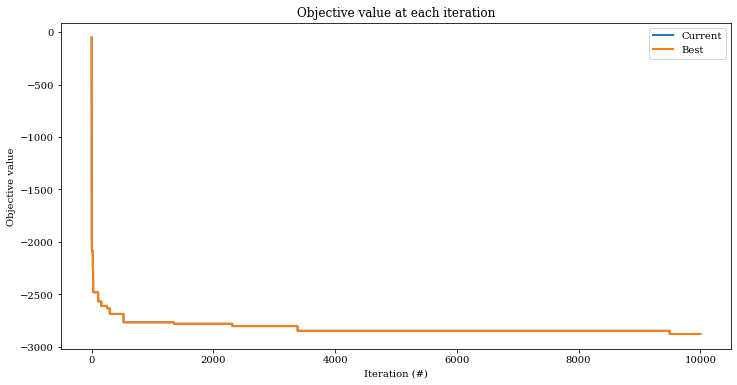

In [15]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax, lw=2)

## Segmented weights

Simple weights continuously updates the weights of the destroy and repair operators. As a consequence, it might overlook that different operators are more effective in the neighbourhood of different solutions.

The `SegmentedWeights` weight scheme attempts to fix this, by fixing the operator weights $\omega_i$ for a number of iterations (the _segment length_). Initially, all weights are set to one, as in `SimpleWeights`. A separate score is tracked for each operator $d$ and $r$, to which the observed scores $s_j$ are added in each iteration where $d$ and $r$ are applied. After the segment concludes, these summed scores are added to the weights $\omega_i$ as a convex combination using a parameter $\theta$ (the _segment decay rate_) as in `SimpleWeights`. The separate score list is then reset to zero, and a new segment begins.

In [16]:
weights = SegmentedWeights(scores=[5, 2, 1, 0.5],
                           num_destroy=2,
                           num_repair=1,
                           seg_decay=0.8,
                           seg_length=500)

alns = make_alns()
res = alns.iterate(init_sol, weights, crit, MaxIterations(10_000))

print(f"Found solution with objective {-res.best_state.objective()}.")

Found solution with objective 2887.0.


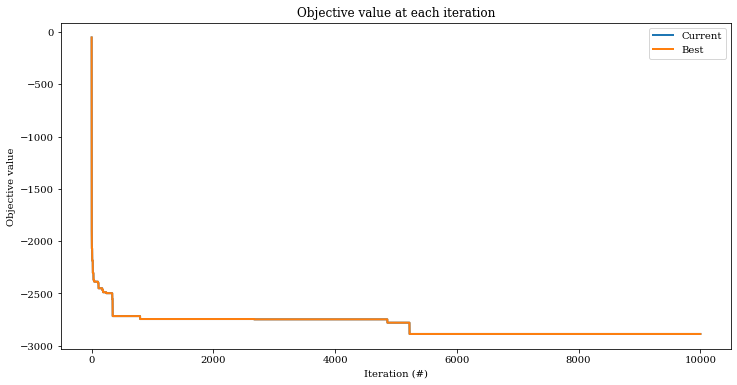

In [17]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax, lw=2)

# Acceptance criteria

We have just looked at the different weight schemes, using a fixed acceptance criterion. Now we flip this around: we fix a weight scheme, and look at the various different acceptance criteria the `alns` package offers.

In [18]:
weights = SegmentedWeights(scores=[5, 2, 1, 0.5],
                           num_destroy=2,
                           num_repair=1,
                           seg_decay=0.8,
                           seg_length=500)

# Hill climbing

This acceptance criterion only accepts better solutions. It was used in the examples explaining the weighting schemes, so we will not repeat it here. You might also be interested in the other example notebooks for the cutting stock and travelling salesman problems, which also rely on this acceptance criterion.

# Record-to-record travel

This criterion accepts solutions when the improvement meets some updating threshold.

In particular, consider the current best solution $s^*$ with objective $f(s^*)$. A new candidate solution $s^c$ is accepted if the improvement $f(s^c) - f(s^*)$ is smaller than some updating threshold $t$. This threshold is initialised at some starting value, and then updated using a step value $u$. There are two ways in which this update can take place:
- _linear_: the threshold is updated linearly, as $t = t - u$.
- _exponential_: the threshold is updated exponentially, as $t = t \times u$.
Finally, the threshold $t$ cannot become smaller than a minimum value, the end threshold.

In [19]:
crit = RecordToRecordTravel(start_threshold=255,
                            end_threshold=5,
                            step=250 / 10_000,
                            method="linear")

alns = make_alns()
res = alns.iterate(init_sol, weights, crit, MaxIterations(10_000))

print(f"Found solution with objective {-res.best_state.objective()}.")

Found solution with objective 2772.0.


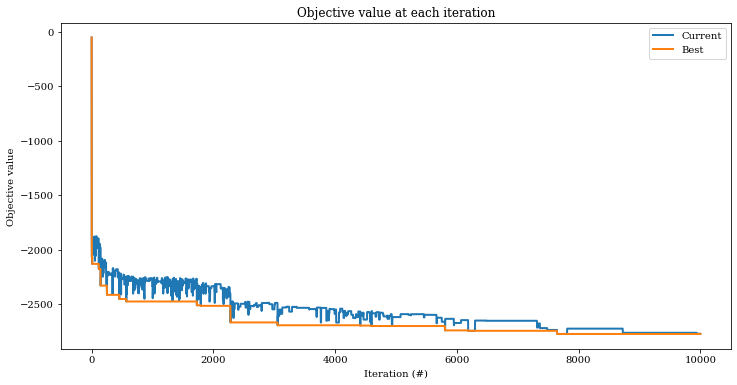

In [20]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax, lw=2)

# Simulated annealing

This criterion accepts solutions when the scaled probability is bigger than some random number, using an updating temperature that drives the probability down. It is very similar to the `RecordToRecordTravel` criterion, but uses a different acceptance scheme.

In particular, a temperature is used, rather than a threshold, and the candidate $s^c$ is compared against the current solution $s$, rather than the current best solution $s^*$. The acceptance probability is calculated as
$$ \exp \left\{ \frac{f(s) - f(s^c)}{t} \right\}, $$
where $t$ is the current temperature.

In [21]:
crit = SimulatedAnnealing(start_temperature=1_000,
                          end_temperature=1,
                          step=1 - 1e-3,
                          method="exponential")

alns = make_alns()
res = alns.iterate(init_sol, weights, crit, MaxIterations(10_000))

print(f"Found solution with objective {-res.best_state.objective()}.")

Found solution with objective 2874.0.


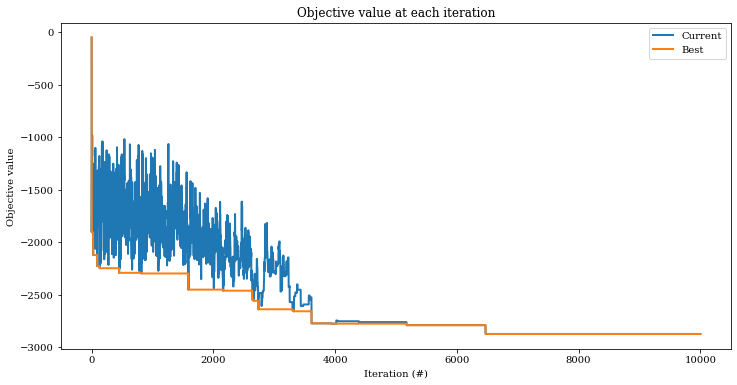

In [22]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax, lw=2)

Rather than a fixed number of iterations, we can also fix the runtime, and allow as many iterations as fit in that timeframe.

In [23]:
crit = SimulatedAnnealing(start_temperature=1_000,
                          end_temperature=1,
                          step=1 - 1e-3,
                          method="exponential")

alns = make_alns()
res = alns.iterate(init_sol, weights, crit, MaxRuntime(60))  # one minute

print(f"Found solution with objective {-res.best_state.objective()}.")

Found solution with objective 2954.0.


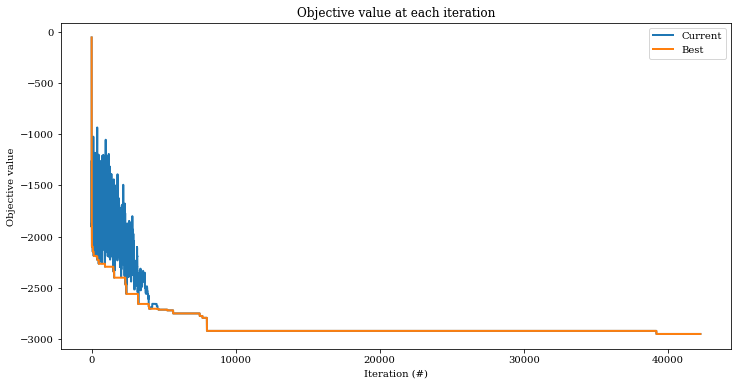

In [24]:
_, ax = plt.subplots(figsize=(12, 6))
res.plot_objectives(ax=ax, lw=2)

# Conclusions

This notebook has shown the various weight schemes, acceptance and stopping criteria that can be used with the `alns` package.
The `alns` package is designed to be flexible, and it is easy to add new weight schemes and criteria yourself, by subclassing `alns.weights.WeightScheme`, `alns.accept.AcceptanceCriterion`, or `alns.stop.StoppingCriterion`.
